In [1]:
!nvidia-smi  ##Get GPU

Thu Jan 12 21:23:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import libraries

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
# Constants
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
COLOR_CHANNELS = 3
N_CLASSES = 10

In [4]:
# check if cuda is available
cuda = torch.cuda.is_available()
print(cuda)

True


# Load raw CIFAR-10 Dataset and Labels

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


**Show images**

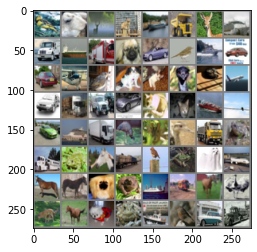

bird  horse deer  cat   ship  truck deer  ship  truck ship  truck dog   car   bird  ship  car   car   plane bird  dog   cat   bird  cat   plane car   truck truck car   cat   cat   ship  bird  car   ship  truck bird  deer  bird  truck frog  truck frog  horse truck bird  frog  dog   plane horse horse dog   frog  ship  truck horse bird  deer  horse dog   frog  ship  bird  car   truck


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Defining the Networks

In this section, we'll build three neural network models: 
* Multi-Layer Perceptron (MLP)
* Convolutional Neural Network (BeIT)


## MLP

In [121]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(torch.nn.Module):
  def __init__(self, input_size, n_hidden_units, n_classes):
    super(MLP, self).__init__()

    h1, h2, h3 = n_hidden_units

    # Add Linear layers
    self.fc1 = nn.Linear(input_size,h1)
    self.fc2 = nn.Linear(h1, h2)
    self.fc3 = nn.Linear(h2, h3)
    self.fc4 = nn.Linear(h3, n_classes) # 10 classes
    self.dropout = nn.Dropout(0.25)

  def forward(self, x):
    x = x.view(-1, input_size) # Flatten out the input layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.dropout(x)
    x = self.fc4(x)
    return F.log_softmax(x)  



In [133]:
# Initialize MLP model
input_size = IMAGE_HEIGHT*IMAGE_WIDTH*COLOR_CHANNELS
n_hidden_units = [512, 256, 128]

net = MLP(input_size, n_hidden_units, N_CLASSES)
if torch.cuda.is_available():
    net = net.cuda()

# Define a Loss function and optimizer

# Train the networks

In [134]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

if torch.cuda.is_available():
    criterion = criterion.cuda()

In [135]:
def predict_mlp(prd_data):
  pred_list = []
  label_list = []
  for i_prd, data_prd in enumerate(prd_data, 0):
        # get the inputs; data is a list of [inputs, labels]
    inputs_prd, labels_prd = data_prd
    if torch.cuda.is_available():
      inputs_prd = inputs_prd.cuda()
      labels_prd = labels_prd.cuda()
        # zero the parameter gradients
        # forward + backward + optimize
    outputs_prd = net(inputs_prd)
    _,pred_outputs = torch.max(outputs_prd.data, 1)
    pred_list.append(pred_outputs.cpu().numpy())
    label_list.append(labels_prd.cpu().numpy())
  return pred_list,label_list

In [136]:
def eval_loss(ev_data):
  losses_ev = []
  accs_ev = []
  running_loss_ev = 0.0
  running_acc_ev = 0.0
  for i_ev, data_ev in enumerate(ev_data, 0):
        # get the inputs; data is a list of [inputs, labels]
    inputs_ev, labels_ev = data_ev
    if torch.cuda.is_available():
      inputs_ev = inputs_ev.cuda()
      labels_ev = labels_ev.cuda()
        # zero the parameter gradients
        # forward + backward + optimize
    outputs_ev = net(inputs_ev)
    loss_ev = criterion(outputs_ev, labels_ev)
        # print statistics
    running_loss_ev += loss_ev.item()
    losses_ev.append(loss_ev.item())

    num_corrects_ev = sum(torch.softmax(outputs_ev, dim=1).argmax(dim=1) == labels_ev)
    acc_ev = 100.0 * num_corrects_ev/len(labels_ev)
    running_acc_ev += acc_ev
    accs_ev.append(acc_ev)
  #return losses_ev,accs_ev
  return running_loss_ev, running_acc_ev
        

In [137]:
train_losses = []
train_acces = []
val_losses = []
val_acces = []
itr = 70
for epoch in range(itr):  # loop over the dataset multiple times
    losses = []
    accs = []
    running_loss = 0.0
    running_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        if torch.cuda.is_available():
              inputs = inputs.cuda()
              labels = labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        losses.append(loss.item())
        #print('outputs:',outputs)
        #print('argmax:',torch.argmax(outputs))
        #print('labels:',labels)
        
        num_corrects = sum(torch.softmax(outputs, dim=1).argmax(dim=1) == labels)
        acc = 100.0 * num_corrects/len(labels)
        running_acc += acc
        accs.append(acc)
 
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] Accumulated loss: {running_loss / 200:.3f}')
    #mean_loss = sum(losses) / len(losses)
    #mean_acc = sum(accs) / len(accs)
    mean_loss = running_loss / len(trainloader)
    mean_acc = running_acc / len(trainloader)

    losses_ev,accs_ev = eval_loss(testloader)
    #mean_loss_ev = sum(losses_ev) / len(losses_ev)
    #mean_acc_ev = sum(accs_ev) / len(accs_ev)
    mean_loss_ev = losses_ev / len(testloader)
    mean_acc_ev = accs_ev / len(testloader)
    print('epoch:' + str(epoch+1) + '/' + str(itr) + ' train loss:' + str(round(mean_loss,3)) ,  ' train acc:' + str(round(mean_acc.item(),3)), 
          ' eval loss:' + str(round(mean_loss_ev,3)) ,  ' eval acc:' + str(round(mean_acc_ev.item(),3))
          )
    train_losses.append(mean_loss)         
    train_acces.append(mean_acc.item())
    val_losses.append(mean_loss_ev)         
    val_acces.append(mean_acc_ev.item())
print('Finished Training')

<ipython-input-121-2be66902cc9f>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


[1,   200] Accumulated loss: 2.298
[1,   400] Accumulated loss: 4.574
[1,   600] Accumulated loss: 6.795
epoch:1/70 train loss:2.234  train acc:17.679  eval loss:2.087  eval acc:25.707
[2,   200] Accumulated loss: 2.043
[2,   400] Accumulated loss: 4.024
[2,   600] Accumulated loss: 5.942
epoch:2/70 train loss:1.954  train acc:30.237  eval loss:1.842  eval acc:33.867
[3,   200] Accumulated loss: 1.821
[3,   400] Accumulated loss: 3.621
[3,   600] Accumulated loss: 5.381
epoch:3/70 train loss:1.782  train acc:35.995  eval loss:1.717  eval acc:38.704
[4,   200] Accumulated loss: 1.704
[4,   400] Accumulated loss: 3.397
[4,   600] Accumulated loss: 5.064
epoch:4/70 train loss:1.682  train acc:39.556  eval loss:1.636  eval acc:41.541
[5,   200] Accumulated loss: 1.622
[5,   400] Accumulated loss: 3.249
[5,   600] Accumulated loss: 4.845
epoch:5/70 train loss:1.607  train acc:42.773  eval loss:1.577  eval acc:43.85
[6,   200] Accumulated loss: 1.561
[6,   400] Accumulated loss: 3.102
[6,   

# Evaluate the network

**Plot Losses for MLP**

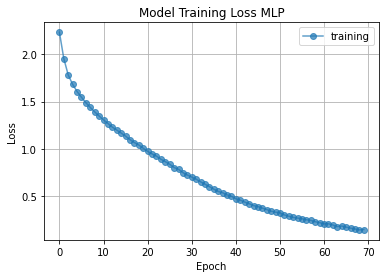

In [138]:

plt.plot(train_losses, label='training', marker='o', alpha=0.7)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.title('Model Training Loss MLP')
plt.savefig('train_loss_mlp.png')

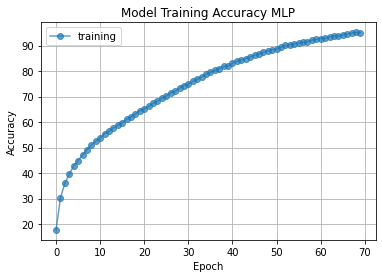

In [139]:
plt.plot(train_acces, label='training', marker='o', alpha=0.7)

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.title('Model Training Accuracy MLP')
plt.savefig('train_accuracy_mlp.png')

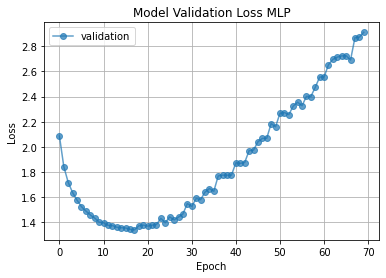

In [140]:
plt.plot(val_losses, label='validation', marker='o', alpha=0.7)

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.title('Model Validation Loss MLP')
plt.savefig('val_loss_mlp.png')

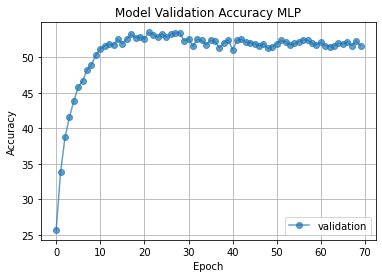

In [141]:
plt.plot(val_acces, label='validation', marker='o', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.title('Model Validation Accuracy MLP')
plt.savefig('val_accuracy_mlp.png')

**Confusion matrix for MLP**

In [142]:
preds_mlp, actual_label = predict_mlp(testloader)

<ipython-input-121-2be66902cc9f>:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [143]:
preds_mlp[0]

array([3, 8, 8, 2, 4, 6, 1, 6, 3, 1, 0, 1, 5, 7, 9, 8, 5, 5, 8, 6, 7, 2,
       0, 9, 4, 5, 4, 4, 9, 6, 5, 4, 4, 4, 9, 1, 5, 9, 9, 5, 4, 6, 7, 4,
       9, 9, 2, 7, 4, 6, 9, 7, 6, 5, 8, 8, 7, 4, 5, 2, 7, 6, 6, 9])

In [144]:
actual_label[0]

array([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0,
       4, 9, 5, 2, 4, 0, 9, 6, 6, 5, 4, 5, 9, 2, 4, 1, 9, 5, 4, 6, 5, 6,
       0, 9, 3, 9, 7, 6, 9, 8, 0, 3, 8, 8, 7, 7, 4, 6, 7, 3, 6, 3])

In [145]:
all_preds_mlp = np.concatenate( preds_mlp, axis=0 )
len(all_preds_mlp)

10000

In [146]:
all_actual_label = np.concatenate( actual_label, axis=0 )
len(all_actual_label)

10000

In [147]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_mlp = confusion_matrix(all_actual_label, all_preds_mlp)
cm_mlp

array([[542,  33,  78,  32,  49,  17,  31,  29, 128,  61],
       [ 47, 580,  21,  30,  21,  11,  30,  24,  73, 163],
       [ 58,  11, 408,  83, 169,  86, 101,  47,  17,  20],
       [ 20,  12, 109, 331,  93, 194, 124,  61,  22,  34],
       [ 27,   5, 131,  47, 518,  68,  98,  75,  18,  13],
       [ 11,   9, 104, 182, 107, 424,  60,  66,  21,  16],
       [  2,  14,  89,  84, 121,  38, 609,  18,  10,  15],
       [ 26,  10,  67,  50, 111, 103,  28, 558,   7,  40],
       [ 82,  57,  18,  33,  36,  16,  13,  13, 669,  63],
       [ 30, 161,  24,  42,  10,  31,  31,  60,  61, 550]])

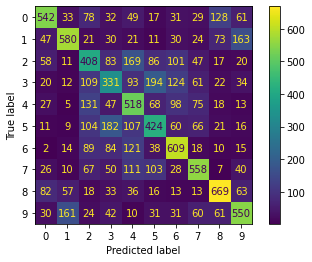

In [148]:
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp)
disp_mlp.plot()
plt.savefig('confusion_matrix_MLP.png')
plt.show()


**Classification Report**

In [149]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 'class 5','class 6', 'class 7', 'class 8','class 9']
report_mlp = classification_report(all_actual_label, all_preds_mlp, target_names=target_names)
report_mlp

'              precision    recall  f1-score   support\n\n     class 0       0.64      0.54      0.59      1000\n     class 1       0.65      0.58      0.61      1000\n     class 2       0.39      0.41      0.40      1000\n     class 3       0.36      0.33      0.35      1000\n     class 4       0.42      0.52      0.46      1000\n     class 5       0.43      0.42      0.43      1000\n     class 6       0.54      0.61      0.57      1000\n     class 7       0.59      0.56      0.57      1000\n     class 8       0.65      0.67      0.66      1000\n     class 9       0.56      0.55      0.56      1000\n\n    accuracy                           0.52     10000\n   macro avg       0.52      0.52      0.52     10000\nweighted avg       0.52      0.52      0.52     10000\n'

## BeIT

In [ ]:
pip install transformers[torch]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.0 MB/s eta 0:00:00


In [ ]:
pip install datasets


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 13.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from transformers import BeitImageProcessor, BeitForImageClassification
import torch
from datasets import load_dataset


In [ ]:
from transformers import BeitImageProcessor, BeitForImageClassification
import torch
feature_extractor = BeitImageProcessor.from_pretrained("microsoft/beit-base-patch16-224")
Beit_IC = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224")


Downloading:   0%|          | 0.00/276 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350M [00:00<?, ?B/s]

In [ ]:
inputs = feature_extractor(image1, return_tensors="pt")
print(inputs)
outputs = Beit_IC(**inputs)

{'pixel_values': tensor([[[[ 0.1137,  0.1686,  0.1843,  ..., -0.1922, -0.1843, -0.1843],
          [ 0.1373,  0.1686,  0.1843,  ..., -0.1922, -0.1922, -0.2078],
          [ 0.1137,  0.1529,  0.1608,  ..., -0.2314, -0.2235, -0.2157],
          ...,
          [ 0.8353,  0.7882,  0.7333,  ...,  0.7020,  0.6471,  0.6157],
          [ 0.8275,  0.7961,  0.7725,  ...,  0.5843,  0.4667,  0.3961],
          [ 0.8196,  0.7569,  0.7569,  ...,  0.0745, -0.0510, -0.1922]],

         [[-0.8039, -0.8118, -0.8118,  ..., -0.8902, -0.8902, -0.8980],
          [-0.7882, -0.7882, -0.7882,  ..., -0.8745, -0.8745, -0.8824],
          [-0.8118, -0.8039, -0.7882,  ..., -0.8902, -0.8902, -0.8902],
          ...,
          [-0.2706, -0.3176, -0.3647,  ..., -0.4275, -0.4588, -0.4824],
          [-0.2706, -0.2941, -0.3412,  ..., -0.4824, -0.5451, -0.5765],
          [-0.2784, -0.3412, -0.3490,  ..., -0.7333, -0.7804, -0.8353]],

         [[-0.5451, -0.4667, -0.4824,  ..., -0.7412, -0.6941, -0.7176],
          [-0

In [ ]:
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", Beit_IC.config.id2label[predicted_class_idx])

Predicted class: tabby, tabby cat


In [ ]:
inputs = feature_extractor(images[2], return_tensors="pt")

with torch.no_grad():
    logits = Beit_IC(**inputs).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(Beit_IC.config.id2label[predicted_label])

speedboat


In [ ]:
pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset

dataset = load_dataset("cifar10")
dataset["train"][100]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x7FC35C020FA0>,
 'label': 6}

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['img', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['img', 'label'],
        num_rows: 10000
    })
})

In [ ]:
def feature_function(example):
  return feature_extractor(example['img'], return_tensors="pt")

In [ ]:
inputs = dataset.map(feature_function,batched = True)

  0%|          | 0/50 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

In [ ]:
small_train_dataset = inputs["train"].shuffle(seed=42).select(range(2000))
small_eval_dataset = inputs["test"].shuffle(seed=42).select(range(500))

In [ ]:
from transformers import TrainingArguments
#training_args = TrainingArguments(output_dir="test_trainer", num_train_epochs = 2, report_to="wandb")

In [ ]:
training_args = TrainingArguments(
    output_dir="imageclassification-cifar10",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy = "epoch",
    learning_rate=6e-5,
    num_train_epochs=5,
    run_name="IC_cifar10",
    logging_dir='./logs',
    save_strategy= 'epoch',
    logging_steps=1,
    load_best_model_at_end = True
)
  

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
training_args

TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_steps=None,
evaluation_strategy=epoch,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
fsdp=[],
fsdp_min_num_params=0,
fsdp_transformer_layer_cls_to_wrap=None,
full_determinism=False,
gradient_accumulation_steps=1,
gradient_checkpointing=False,
greater_is_better=False,
group_by_length=False,
half_precision_backend=auto,
hub_model_id=None,
hub_private_repo=False,
hub_strategy=every_save,
hub_token=<HUB_TOKEN>,
ignore_data_skip=False,
include_inputs_for_metrics=False,
jit_mode_eval=False,
label_

In [ ]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 6.0 MB/s eta 0:00:00


In [ ]:
import evaluate
metric = evaluate.load("accuracy")

In [ ]:
import numpy as np
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    print('labels:',labels)
    print('logits:',np.argmax(logits, axis=-1))
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer

#training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
trainer = Trainer(
    model=Beit_IC,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
his = trainer.train()

The following columns in the training set don't have a corresponding argument in `BeitForImageClassification.forward` and have been ignored: img. If img are not expected by `BeitForImageClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 5000
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 3125
  Number of trainable parameters = 86530984


Epoch,Training Loss,Validation Loss,Accuracy
1,0.502600,0.294116,0.924500
2,1.277000,0.281722,0.938500
3,0.002100,0.231993,0.958000
4,0.000100,0.163215,0.971000
5,0.000300,0.174979,0.963000


The following columns in the evaluation set don't have a corresponding argument in `BeitForImageClassification.forward` and have been ignored: img. If img are not expected by `BeitForImageClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8


labels: [8 5 9 ... 1 7 1]
logits: [8 5 9 ... 1 7 1]


Saving model checkpoint to imageclassification-cifar10/checkpoint-625
Configuration saved in imageclassification-cifar10/checkpoint-625/config.json
Model weights saved in imageclassification-cifar10/checkpoint-625/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BeitForImageClassification.forward` and have been ignored: img. If img are not expected by `BeitForImageClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8


labels: [8 5 9 ... 1 7 1]
logits: [8 5 9 ... 1 7 1]


Saving model checkpoint to imageclassification-cifar10/checkpoint-1250
Configuration saved in imageclassification-cifar10/checkpoint-1250/config.json
Model weights saved in imageclassification-cifar10/checkpoint-1250/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BeitForImageClassification.forward` and have been ignored: img. If img are not expected by `BeitForImageClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8


labels: [8 5 9 ... 1 7 1]
logits: [8 5 9 ... 1 7 1]


Saving model checkpoint to imageclassification-cifar10/checkpoint-1875
Configuration saved in imageclassification-cifar10/checkpoint-1875/config.json
Model weights saved in imageclassification-cifar10/checkpoint-1875/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BeitForImageClassification.forward` and have been ignored: img. If img are not expected by `BeitForImageClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8


labels: [8 5 9 ... 1 7 1]
logits: [8 5 9 ... 1 7 1]


Saving model checkpoint to imageclassification-cifar10/checkpoint-2500
Configuration saved in imageclassification-cifar10/checkpoint-2500/config.json
Model weights saved in imageclassification-cifar10/checkpoint-2500/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BeitForImageClassification.forward` and have been ignored: img. If img are not expected by `BeitForImageClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 2000
  Batch size = 8


labels: [8 5 9 ... 1 7 1]
logits: [8 5 9 ... 1 7 1]


Saving model checkpoint to imageclassification-cifar10/checkpoint-3125
Configuration saved in imageclassification-cifar10/checkpoint-3125/config.json
Model weights saved in imageclassification-cifar10/checkpoint-3125/pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from imageclassification-cifar10/checkpoint-2500 (score: 0.16321545839309692).


In [ ]:
history_beit = trainer.state.log_history
history_beit

[{'loss': 2.1495, 'learning_rate': 5.99808e-05, 'epoch': 0.0, 'step': 1},
 {'loss': 2.5485,
  'learning_rate': 5.9961600000000005e-05,
  'epoch': 0.0,
  'step': 2},
 {'loss': 3.8997,
  'learning_rate': 5.9942400000000004e-05,
  'epoch': 0.0,
  'step': 3},
 {'loss': 4.1162, 'learning_rate': 5.99232e-05, 'epoch': 0.01, 'step': 4},
 {'loss': 3.8013, 'learning_rate': 5.9904e-05, 'epoch': 0.01, 'step': 5},
 {'loss': 2.3904, 'learning_rate': 5.98848e-05, 'epoch': 0.01, 'step': 6},
 {'loss': 3.2983, 'learning_rate': 5.98656e-05, 'epoch': 0.01, 'step': 7},
 {'loss': 2.481,
  'learning_rate': 5.9846400000000004e-05,
  'epoch': 0.01,
  'step': 8},
 {'loss': 2.5216, 'learning_rate': 5.98272e-05, 'epoch': 0.01, 'step': 9},
 {'loss': 2.5042, 'learning_rate': 5.9808e-05, 'epoch': 0.02, 'step': 10},
 {'loss': 2.3319,
  'learning_rate': 5.9788800000000006e-05,
  'epoch': 0.02,
  'step': 11},
 {'loss': 1.356,
  'learning_rate': 5.9769600000000005e-05,
  'epoch': 0.02,
  'step': 12},
 {'loss': 2.2813,
 

In [ ]:
history_beit[624*2]['loss']

0.1684

In [ ]:
beit_losses = []
for i in range(5):
  loss_ep = [d['loss'] for d in history_beit if ('loss' in d) and (d['epoch']) and (d['step'] < 625 * (i+1))]
  average = sum(loss_ep) / len(loss_ep)
  beit_losses.append(average)


In [ ]:
beit_losses

[0.6119937198067639,
 0.3896804173354738,
 0.2767033137359694,
 0.21068565705127712,
 0.16925273950656097]

**Plot loss**

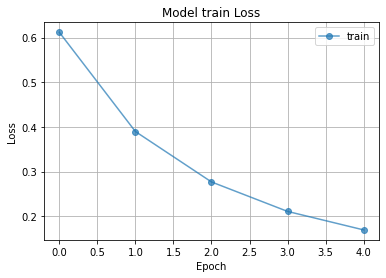

In [ ]:

plt.plot(beit_losses, label='train', marker='o', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.title('Model train Loss')
plt.savefig('beit_losses.png')

In [ ]:
loss_eval_ep = [d['eval_loss'] for d in history_beit if ('eval_loss' in d)]
loss_eval_ep

[0.2941163182258606,
 0.2817220687866211,
 0.2319926917552948,
 0.16321545839309692,
 0.17497867345809937]

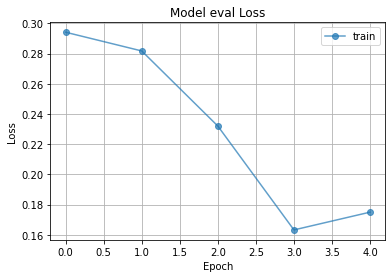

In [ ]:

plt.plot(loss_eval_ep, label='train', marker='o', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.title('Model eval Loss')
plt.savefig('beit_losses_eval.png')

**Confusion matrix for BEiT**

In [ ]:
preds = trainer.predict(small_eval_dataset)

The following columns in the test set don't have a corresponding argument in `BeitForImageClassification.forward` and have been ignored: img. If img are not expected by `BeitForImageClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 2000
  Batch size = 8


labels: [8 5 9 ... 1 7 1]
logits: [8 5 9 ... 1 7 1]


In [ ]:
preds.label_ids

array([8, 5, 9, ..., 1, 7, 1])

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(small_eval_dataset['label'], preds.label_ids)
cm

array([[198,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 215,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 200,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 192,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 209,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 187,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 188,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 207,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 179,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0, 225]])

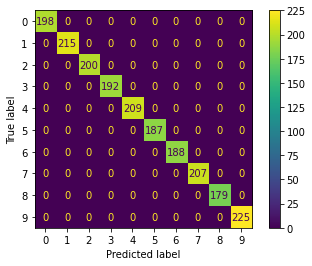

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig('confusion_matrix_beit.png')
plt.show()


**Classification Report**

In [ ]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 'class 5','class 6', 'class 7', 'class 8','class 9']
report = classification_report(small_eval_dataset['label'], preds.label_ids, target_names=target_names)
report

'              precision    recall  f1-score   support\n\n     class 0       1.00      1.00      1.00       198\n     class 1       1.00      1.00      1.00       215\n     class 2       1.00      1.00      1.00       200\n     class 3       1.00      1.00      1.00       192\n     class 4       1.00      1.00      1.00       209\n     class 5       1.00      1.00      1.00       187\n     class 6       1.00      1.00      1.00       188\n     class 7       1.00      1.00      1.00       207\n     class 8       1.00      1.00      1.00       179\n     class 9       1.00      1.00      1.00       225\n\n    accuracy                           1.00      2000\n   macro avg       1.00      1.00      1.00      2000\nweighted avg       1.00      1.00      1.00      2000\n'